# <h1><center>Distinguishing CG and PG by Identifying Traces of Demosaicing</center></h1>

<center>Rayan El Helou; Yukun Tan; Virisha Timmaraju</center>

<h3>There are four primary steps involved:</h3>

<h4>A. Selecting an appropriate feature</h4>

<h4>B. Testing feature for a training set</h4>

<h4>C. Statistically modeling the problem</h4>

<h4>D. Testing the decision making model</h4>

# A. Selecting an appropriate feature:# 

After reviewing multiple features, we decided on a feature that identifies traces of demosaicing.

Introduction to Demosaicing:
Demosaicing is necessarily one of the first operations applied to an image in the digital camera. Nearly all digital cameras contain an image sensor with a color filter array. Typically, a demosaicing algorithm, also called color filter array interpolation, is applied to the raw image to estimate the pixel value for each color component. An interpolated pixel value is produced with a weighted linear combination of neighboring pixel values. The weights directly affect the variance of the distribution from which the interpolated pixel value is drawn. This pattern of variances can be detected and is the basis for detecting demosaicing. In our implementation, we consider only the green channel of the image to demonstrate our approach.

Algorithm:

1.The image i(x, y) is convolved with a highpass operator h(x, y) (Laplacian, in our case), in order to remove low frequency information and enhance the embedded periodicity when demosaicing has occurred.

2.Next, estimates of the variance of each photosite are made using Maximum Likelihood Estimation. After application of h(x, y), each pixel value is assumed to be drawn from a normal distribution with a particular variance, and the variance along diagonals is assumed to be constant for images that have undergone demosaicing((note the variance varies periodically across different diagonals).

3.To compute a MLE estimate of the variance, the statistical variance of the pixel values along each diagonal is found. in place of actually computing variance,we use the computationally simpler mean of the absolute values of each diagonal in the image. This projects the image down to a single-dimension signal, m(d), were m(d) represents the estimate of the variance corresponding to the dth diagonal, Nd is the number of pixels along the dth diagonal and is used for normalization.

$$m(d)=\frac{\sum_{x+y=d}\Big|h(x,y)*i(x,y)\Big|}{N_d}$$

4.To find the periodicity in m(d), the DFT is computed to find |M(e^jω)|. A relatively high peak at frequency ω = π indicates that the image has undergone interpolation by afactor of two and is characteristic of demosaicing. where k is the median value of the spectrum, excluding the DC value. Normalizing by k was found to be important to distinguish between true demosaicing and images containing signals or noise with large energy across the frequency spectrum. The peak magnitude at ω = π is quantified as follows:

$$s = \frac{\Big|M(e^{j\omega})\Big|_{\omega=\pi}}{k}$$


# B. Testing feature for a training set

In [1]:
from PIL import Image
import numpy as np
import math
from scipy import signal as sg
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy
import csv
from pylab import *
import pandas as pd 

<h3>The code below has been simulated to save the results in csv files. Those files are extracted as shown below.</h3>

In [2]:
if 0: # To skip simulation of all pictures
    s_photo = []
    for filename in glob.glob('nature photo/*.jpg'):
        im = Image.open(filename)
        imarray = np.array(im)
        imarray[:,:,0] = 0
        imarray[:,:,2] = 0
        g = imarray[:,:,1]/255.0 #normalizing
        h = np.array([[0,1,0],[1,-4,1],[0,1,0]])
        cov = sg.fftconvolve(g,h, mode='valid')
        fo = np.fliplr(cov)
        m = []
        for d in range((fo.shape[1] - 1), (- fo.shape[0]), -1):
            m.append(np.mean(np.abs(np.diag(fo, k=d))))
        M = np.abs(np.fft.fft(m))
        k = np.median(M[1::])
        a = len(M)/2
        b = int(math.floor(a)+1)
        mid = M[b]
        s_photo.append(mid/k)
    print(s_photo)
    df = pd.DataFrame(s_photo)
    df.to_csv("s_project_photo.csv")

In [3]:
if 0: # To skip simulation of all pictures
    s_CG = []
    for filename in glob.glob('TrainingSetSynthetic/*.png'):
        im = Image.open(filename)
        imarray = np.array(im)
        imarray[:,:,0] = 0
        imarray[:,:,2] = 0
        im = Image.open(filename)
        imarray = np.array(im)
        imarray[:,:,0] = 0
        imarray[:,:,2] = 0
        g = imarray[:,:,1]/255.0 #normalizing
        h = np.array([[0,1,0],[1,-4,1],[0,1,0]])
        cov = sg.fftconvolve(g,h, mode='valid')
        fo = np.fliplr(cov)
        m = []
        for d in range((fo.shape[1] - 1), (- fo.shape[0]), -1):
            m.append(np.mean(np.abs(np.diag(fo, k=d))))
        M = np.abs(np.fft.fft(m))
        k = np.median(M[1::])
        a = len(M)/2
        b = int(math.floor(a)+1)
        mid = M[b]
        s_CG.append(mid/k)
        g = imarray[:,:,1]/255.0 #normalizing
        h = np.array([[0,1,0],[1,-4,1],[0,1,0]])
        cov = sg.fftconvolve(g,h, mode='valid')
        fo = np.fliplr(cov)
        m = []
        for d in range((fo.shape[1] - 1), (- fo.shape[0]), -1):
            m.append(np.mean(np.abs(np.diag(fo, k=d))))
        M = np.abs(np.fft.fft(m))
        k = np.median(M[1::])
        a = len(M)/2
        b = int(math.floor(a)+1)
        mid = M[b]
        s_CG.append(mid/k)
    print(s_CG)
    df = pd.DataFrame(s_CG)
    df.to_csv("s_project_CG.csv")

# C. Statistically modeling the problem

<h3>The following code below demonstrates the extraction of the previously obtained csv files.</h3>

In [4]:
df_CG = pd.DataFrame.from_csv("feature_value/s_project_CG.csv")
s_CG = []
for i in range(len(df_CG)):
    s_CG.append(df_CG["0"][i])
df_photo = pd.DataFrame.from_csv("feature_value/s_project_photo.csv")
s_photo = []
for i in range(len(df_photo)):
    s_photo.append(df_photo["0"][i])

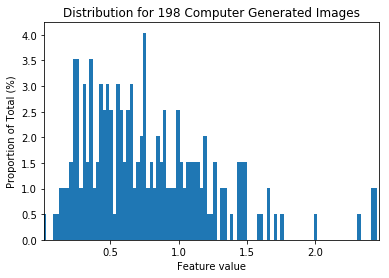

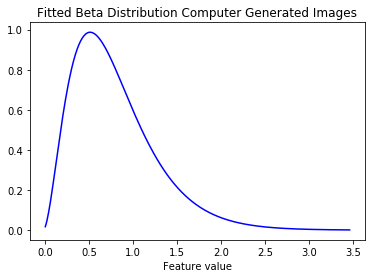

In [5]:
# CG distribution

np.seterr(divide='ignore', invalid='ignore')

hist_CG,bin_CG = np.histogram(s_CG,100)
hist_CG = 100*hist_CG/len(s_CG)
y_CG = scipy.stats.beta.fit(s_CG)
y_CG = scipy.stats.beta.pdf(bin_CG,*y_CG)
plt.bar(bin_CG[:-1], hist_CG, width = bin_CG[1]-bin_CG[0])
plt.xlim(min(bin_CG), max(bin_CG))
plt.xlabel('Feature value')
plt.ylabel('Proportion of Total (%)')
plt.title("Distribution for 198 Computer Generated Images")
plt.show()

x = np.arange(0,max(bin_CG)+1,0.01)
fig, ax = plt.subplots(1, 1)
y_CG = scipy.stats.beta.fit(s_CG)
plt.xlabel('Feature value')
plt.title("Fitted Beta Distribution Computer Generated Images")
ax.plot(x, scipy.stats.beta.pdf(x,*y_CG), 'b-')
plt.show()

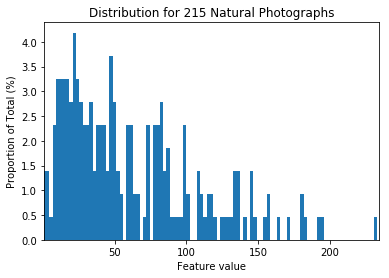

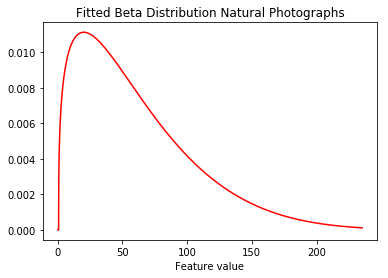

In [6]:
# Photo distribution

np.seterr(divide='ignore', invalid='ignore')
hist_photo,bin_photo = np.histogram(s_photo,100)
hist_photo = 100*hist_photo/len(s_photo)
y_photo = scipy.stats.beta.fit(s_photo)
y_photo = scipy.stats.beta.pdf(bin_photo,*y_photo)
plt.bar(bin_photo[:-1], hist_photo, width = bin_photo[1]-bin_photo[0])
plt.xlim(min(bin_photo), max(bin_photo))
plt.xlabel('Feature value')
plt.ylabel('Proportion of Total (%)')
plt.title("Distribution for 215 Natural Photographs")
plt.show()

x = np.arange(0,max(bin_photo)+1,0.01)
fig, ax = plt.subplots(1, 1)
y_photo = scipy.stats.beta.fit(s_photo)
plt.xlabel('Feature value')
plt.title("Fitted Beta Distribution Natural Photographs")
ax.plot(x, scipy.stats.beta.pdf(x,*y_photo), 'r-')
plt.show()

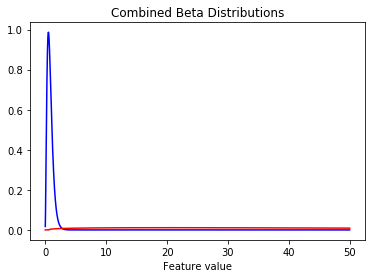

In [7]:
# Both

x = np.arange(0,50,0.01)
fig, ax = plt.subplots(1, 1)
y_CG = scipy.stats.beta.fit(s_CG)
y_photo = scipy.stats.beta.fit(s_photo)
plt.xlabel('Feature value')
plt.title("Combined Beta Distributions")
ax.plot(x, scipy.stats.beta.pdf(x,*y_CG), 'b-')
plt.xlabel('Feature value')
plt.title("Combined Beta Distributions")
ax.plot(x, scipy.stats.beta.pdf(x,*y_photo), 'r-')
plt.show()

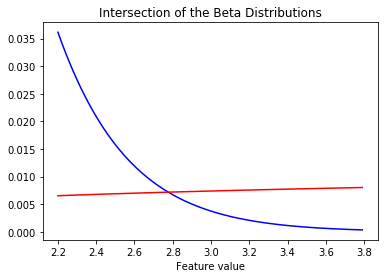

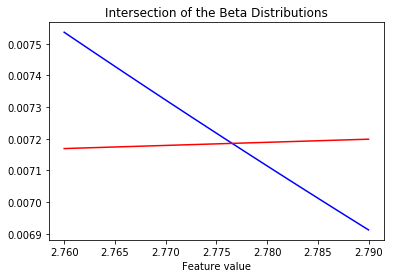

In [8]:
# Intersection

x = np.arange(2.2,3.8,0.01)
fig, ax = plt.subplots(1, 1)
y_CG = scipy.stats.beta.fit(s_CG)
y_photo = scipy.stats.beta.fit(s_photo)
plt.xlabel('Feature value')
plt.title("Intersection of the Beta Distributions")
ax.plot(x, scipy.stats.beta.pdf(x,*y_CG), 'b-')
ax.plot(x, scipy.stats.beta.pdf(x,*y_photo), 'r-')
plt.show()

x = np.arange(2.76,2.79,0.001)
fig, ax = plt.subplots(1, 1)
y_CG = scipy.stats.beta.fit(s_CG)
y_photo = scipy.stats.beta.fit(s_photo)
plt.xlabel('Feature value')
plt.title("Intersection of the Beta Distributions")
ax.plot(x, scipy.stats.beta.pdf(x,*y_CG), 'b-')
ax.plot(x, scipy.stats.beta.pdf(x,*y_photo), 'r-')
plt.show()

# D. Testing the decision making model

We know from the classical setting that for choosing between two parameters $\theta_0$ and $\theta_1$, based on probability distributions $f(y|\theta_0)$ and $f(y|\theta_1)$ and prior probabilities $\pi_0$ and $\pi_1$, respectively, the following is true.

We choose $\theta_0$ if
$$f(y|\theta_0)\pi_0>f(y|\theta_1)\pi_1$$
and we choose $\theta_1$ if
$$f(y|\theta_0)\pi_0<f(y|\theta_1)\pi_1$$

Here, we have assumed that the prior probabilities are both $1/2$ because we assume that we are given an image that can be either a photograph or a computer generated image with equal likelihood, and we also tested our feature using approximately the same number (200) of images for both photographs and computer generated images.

Therefore, the following equality holds:
$$\pi_0 = \pi_1$$

Hence, the intersections of the Beta distributions, shown as 2.777 in the figure above, is the decision threshold on the feature. In other words, after extracting the feature value of a given image, we compare it to 2.777. If the feature value is greater than 2.777, we conclude that it is a photograph. Otherwise, we conclude that it is a computer generated image.

In [9]:
# Measure Accuracy based on Threshold
 
intersection_threshold = 2.777
print('Model-based threshold on feature using Beta distributions:')
print(intersection_threshold)
n_CG_correct = 0
for i in range(len(s_CG)):
    if s_CG[i]<intersection_threshold:
        n_CG_correct = n_CG_correct + 1
n_photo_correct = 0
for i in range(len(s_photo)):
    if s_photo[i]>intersection_threshold:
        n_photo_correct = n_photo_correct + 1
accuracy = (n_CG_correct + n_photo_correct)/(len(s_CG) + len(s_photo))
print('Corresponding Accuracy:')
print(100*accuracy)

accuracy = 0
for threshold in np.arange(1,4,0.01):
    n_CG_correct = 0
    for i in range(len(s_CG)):
        if s_CG[i]<threshold:
            n_CG_correct = n_CG_correct + 1
    n_photo_correct = 0
    for i in range(len(s_photo)):
        if s_photo[i]>threshold:
            n_photo_correct = n_photo_correct + 1
    if (n_CG_correct + n_photo_correct)/(len(s_CG) + len(s_photo))>= accuracy:
        accuracy = (n_CG_correct + n_photo_correct)/(len(s_CG) + len(s_photo))
        best_threshold = threshold
print('Traning-set-based threshold on feature:')
print(best_threshold)
print('Corresponding Accuracy:')
print(100*accuracy)

Model-based threshold on feature using Beta distributions:
2.777
Corresponding Accuracy:
99.75786924939467
Traning-set-based threshold on feature:
2.99
Corresponding Accuracy:
99.75786924939467


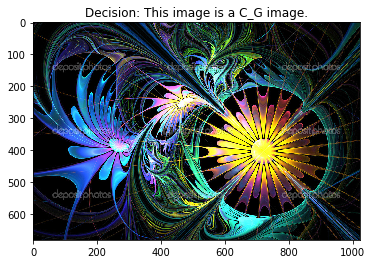

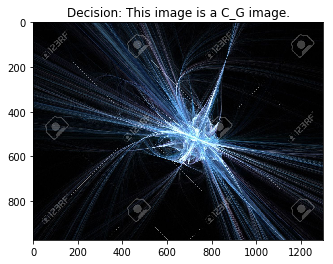

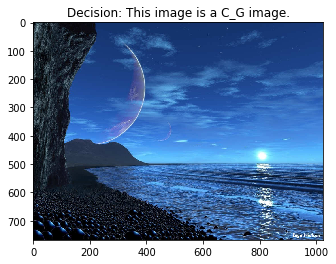

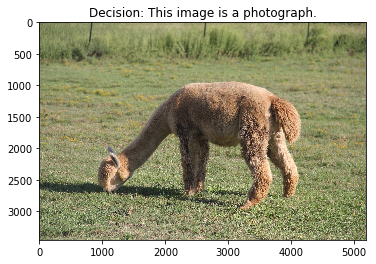

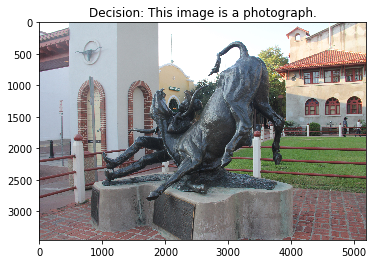

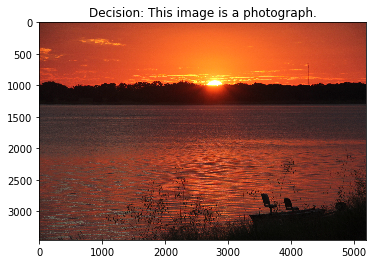

In [10]:
# Test algorithm on pictures

for filename in glob.glob('picture/*.jpg'):
    im = Image.open(filename)
    imarray = np.array(im)
    imarray[:,:,0] = 0
    imarray[:,:,2] = 0
    g = imarray[:,:,1]/255.0
    h = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    cov = sg.fftconvolve(g,h, mode='valid')
    fo = np.fliplr(cov)
    m = []
    for d in range((fo.shape[1] - 1), (- fo.shape[0]), -1):
        m.append(np.mean(np.abs(np.diag(fo, k=d))))
    M = np.abs(np.fft.fft(m))
    k = np.median(M[1::])
    a = len(M)/2
    b = int(math.floor(a)+1)
    mid = M[b]
    s = mid/k
    threshold = intersection_threshold
    
    imshow(im)
    if s>threshold:
        plt.title("Decision: This image is a photograph.")
    else:
        plt.title("Decision: This image is a C_G image.")
    show()